In [1]:
import wfdb
import os
import numpy as np
from glob import glob
from tqdm import tqdm

In [ ]:
class LTAFDBLoader:
    def __init__(self, data_dir='.'):
        """
        初始化LTAF数据库加载器
        
        Args:
            data_dir: 数据文件所在的目录路径
        """
        self.data_dir = data_dir
        
    def get_all_record_names(self):
        """获取目录中所有的记录名称"""
        hea_files = glob(os.path.join(self.data_dir, "*.hea"))
        record_names = [os.path.basename(f).replace('.hea', '') for f in hea_files]
        # 按数字排序
        record_names.sort(key=lambda x: int(x) if x.isdigit() else x)
        return record_names
    
    def load_single_record(self, record_name):
        """
        加载单个心电记录
        
        Args:
            record_name: 记录名称，如 '00', '01'
            
        Returns:
            dict: 包含信号、元数据和注释的字典
        """
        try:
            record_path = os.path.join(self.data_dir, record_name)
            
            # 读取信号和头文件信息
            signals, fields = wfdb.rdsamp(record_path)
            
            # 读取注释文件
            annotation = wfdb.rdann(record_path, 'atr')
            
            return {
                'record_name': record_name,
                'signals': signals,
                'fields': fields,
                'annotation': annotation,
                'fs': fields['fs'],
                'sig_names': fields['sig_name'],
                'n_samples': signals.shape[0],
                'n_channels': signals.shape[1],
                'duration_hours': signals.shape[0] / fields['fs'] / 3600
            }
            
        except Exception as e:
            print(f"\n加载记录 {record_name} 时出错: {e}")
            return None
    
    def load_all_records(self, limit=None, desc="加载心电记录"):
        """
        使用tqdm进度条加载所有心电记录
        
        Args:
            limit: 可选，限制加载的记录数量
            desc: 进度条描述
            
        Returns:
            list: 包含所有记录数据的列表
        """
        record_names = self.get_all_record_names()
        
        if limit:
            record_names = record_names[:limit]
        
        ecg_records = []
        failed_records = []
        
        print(f"开始加载 {len(record_names)} 条记录...")
        
        # 使用tqdm创建进度条
        for record_name in tqdm(record_names, desc=desc, unit="record", 
                                bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
            record_data = self.load_single_record(record_name)
            
            if record_data is not None:
                ecg_records.append(record_data)
            else:
                failed_records.append(record_name)
        
        # 显示统计信息
        if failed_records:
            print(f"\n警告: {len(failed_records)} 条记录加载失败: {failed_records}")
        
        print(f"成功加载 {len(ecg_records)}/{len(record_names)} 条记录")
        if ecg_records:
            total_hours = sum([rec['duration_hours'] for rec in ecg_records])
            print(f"总时长: {total_hours:.2f} 小时")
        
        return ecg_records

In [3]:
# 1. 创建加载器
data_dir = "ltafdb"  # 当前目录，根据实际情况修改
loader = LTAFDBLoader(data_dir)

# 2. 加载所有记录
all_ecg_records = loader.load_all_records()

# 3. 查看加载的数据
print(f"\n已加载 {len(all_ecg_records)} 条记录")
for i, record in enumerate(all_ecg_records[:3]):  # 显示前3条
    print(f"\n记录 {i+1}: {record['record_name']}")
    print(f"  采样率: {record['fs']} Hz")
    print(f"  信号形状: {record['signals'].shape}")
    print(f"  信号名称: {record['sig_names']}")
    print(f"  持续时间: {record['n_samples']/record['fs']/3600:.2f} 小时")
    print(f"  注释数量: {len(record['annotation'].symbol)}")
    
    # 统计房颤节律的比例
    af_symbols = [sym for sym in record['annotation'].symbol if sym == '(AFIB']
    if len(record['annotation'].symbol) > 0:
        af_ratio = len(af_symbols) / len(record['annotation'].symbol) * 100
        print(f"  房颤节律比例: {af_ratio:.1f}%")

开始加载 84 条记录...


加载心电记录: 100%|██████████| 84/84 [01:20<00:00]

✅ 成功加载 84/84 条记录
📊 总时长: 1960.60 小时

已加载 84 条记录

记录 1: 00
  采样率: 128 Hz
  信号形状: (9661440, 2)
  信号名称: ['ECG', 'ECG']
  持续时间: 20.97 小时
  注释数量: 106337
  房颤节律比例: 0.0%

记录 2: 01
  采样率: 128 Hz
  信号形状: (9477120, 2)
  信号名称: ['ECG', 'ECG']
  持续时间: 20.57 小时
  注释数量: 91509
  房颤节律比例: 0.0%

记录 3: 03
  采样率: 128 Hz
  信号形状: (11182080, 2)
  信号名称: ['ECG', 'ECG']
  持续时间: 24.27 小时
  注释数量: 84266
  房颤节律比例: 0.0%


In [ ]:
# 4. Visualize specific record
def visualize_specific_record_improved(record_data, record_name=None, start_sec=0, duration_sec=30, save_plots=True):
    """
    改进版：可视化单条ECG记录，正确显示数据库标注
    
    Args:
        record_data: 记录数据字典
        record_name: 记录名称
        start_sec: 开始时间（秒）
        duration_sec: 显示时长（秒）
        save_plots: 是否保存图形
    """
    if record_name is None:
        record_name = record_data.get('record_name', 'Unknown')
    
    print(f"\nVisualizing record: {record_name}")
    print(f"Time window: {start_sec}-{start_sec+duration_sec} seconds")
    
    fs = record_data['fs']
    signals = record_data['signals']
    annotation = record_data.get('annotation', None)
    
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create output directory
    import os
    output_dir = f"visualizations/{record_name}"
    if save_plots:
        os.makedirs(output_dir, exist_ok=True)
    
    # ========== 1. 基础信号可视化 ==========
    print("1. Plotting basic ECG signal...")
    n_channels = signals.shape[1]
    start_sample = int(start_sec * fs)
    end_sample = int((start_sec + duration_sec) * fs)
    end_sample = min(end_sample, signals.shape[0])
    
    time_axis = np.arange(start_sample, end_sample) / fs
    
    fig1, axes1 = plt.subplots(n_channels, 1, figsize=(15, 3*n_channels), 
                              sharex=True, gridspec_kw={'hspace': 0.1})
    
    if n_channels == 1:
        axes1 = [axes1]
    
    colors = ['#1f77b4', '#ff7f0e']  # Blue and orange
    
    for i, ax in enumerate(axes1):
        signal_segment = signals[start_sample:end_sample, i]
        ax.plot(time_axis, signal_segment, color=colors[i % len(colors)], 
               linewidth=0.8, alpha=0.8)
        
        channel_name = record_data['sig_names'][i] if 'sig_names' in record_data else f'Channel {i+1}'
        ax.set_ylabel(f'{channel_name}\n(mV)', fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_facecolor('#f8f9fa')
        
        # Add statistics
        mean_val = np.mean(signal_segment)
        std_val = np.std(signal_segment)
        ax.text(0.02, 0.95, f'Mean: {mean_val:.2f}mV\nStd: {std_val:.2f}mV', 
               transform=ax.transAxes, fontsize=8,
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    axes1[-1].set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
    plt.suptitle(f'Record {record_name} - ECG Signal ({duration_sec} seconds)', 
                fontsize=12, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'{output_dir}/1_basic_ecg.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # ========== 2. 带标注的可视化（关键修复！） ==========
    if annotation is not None:
        print("2. Plotting ECG signal with annotations...")
        
        # 获取当前时间范围内的标注
        ann_samples = annotation.sample
        ann_symbols = annotation.symbol
        
        mask = (ann_samples >= start_sample) & (ann_samples <= end_sample)
        visible_samples = ann_samples[mask]
        visible_symbols = [ann_symbols[i] for i in range(len(ann_samples)) if mask[i]]
        visible_times = visible_samples / fs
        
        # 统计标注类型
        from collections import Counter
        ann_counter = Counter(visible_symbols)
        
        fig2, (ax_ecg, ax_ann) = plt.subplots(2, 1, figsize=(15, 8), 
                                            gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})
        
        # 绘制ECG信号
        for i in range(min(2, n_channels)):  # 最多显示2个通道
            signal_segment = signals[start_sample:end_sample, i]
            ax_ecg.plot(time_axis, signal_segment, 
                       color=colors[i % len(colors)], 
                       linewidth=0.6, alpha=0.7,
                       label=record_data['sig_names'][i] if 'sig_names' in record_data else f'Channel {i+1}')
        
        ax_ecg.set_ylabel('Amplitude (mV)', fontsize=10)
        ax_ecg.grid(True, alpha=0.2)
        ax_ecg.legend(fontsize=8)
        
        # 绘制标注
        if len(visible_samples) > 0:
            # 正确的标注颜色映射
            ann_colors = {
                'N': 'green',           # 正常心搏
                'V': 'red',             # 室性早搏
                'A': 'orange',          # 房性早搏
                'L': 'purple',          # 左束支传导阻滞
                'R': 'brown',           # 右束支传导阻滞
                '/': 'gray',            # 起搏心搏
                '+': 'pink',            # 噪声
                '|': 'lightgray',       # 伪影
                '~': 'cyan',            # 信号质量变化
                's': 'magenta',         # 室上性早搏
                'S': 'magenta',         # 室上性早搏
                'J': 'olive',           # 结性早搏
                'F': 'teal',            # 融合波
                
                # 节律标注 - 这是您之前看不到的关键！
                '(AFIB': 'darkred',     # 房颤开始
                ')': 'darkred',         # 节律结束
                '(AFL': 'darkorange',   # 房扑开始
                '(N': 'darkgreen',      # 正常节律开始
                '(VT': 'darkblue',      # 室速开始
                '(SBR': 'navy',         # 窦缓开始
                '(SVTA': 'indigo',      # 室上速开始
            }
            
            # 用于图例的标注名称映射
            ann_names = {
                'N': 'Normal Beat',
                'V': 'PVC',
                'A': 'APC',
                'L': 'LBBB',
                'R': 'RBBB',
                '/': 'Paced',
                '+': 'Noise',
                '|': 'Artifact',
                '~': 'Signal Change',
                's': 'SVPB',
                'S': 'SVPB',
                'J': 'JPB',
                'F': 'Fusion',
                '(AFIB': 'AFib Start',
                ')': 'Rhythm End',
                '(AFL': 'AFlutter Start',
                '(N': 'Normal Rhythm',
                '(VT': 'VT Start',
                '(SBR': 'Sinus Brady',
                '(SVTA': 'SVT Start',
            }
            
            # 用于跟踪已添加的图例
            added_to_legend = set()
            
            for time, symbol in zip(visible_times, visible_symbols):
                color = ann_colors.get(symbol, 'black')
                label = ann_names.get(symbol, symbol)
                
                # 在ECG上标记
                ax_ecg.axvline(x=time, color=color, alpha=0.3, linestyle='--', linewidth=0.5)
                
                # 在标注轴上标记
                if symbol in ann_colors:
                    # 只在图例中添加一次
                    if symbol not in added_to_legend:
                        ax_ann.scatter(time, 0.5, color=color, s=80, marker='^', 
                                     label=label, zorder=5)
                        added_to_legend.add(symbol)
                    else:
                        ax_ann.scatter(time, 0.5, color=color, s=80, marker='^', zorder=5)
        
        ax_ann.set_ylim(0, 1)
        ax_ann.set_xlabel('Time (seconds)', fontsize=10)
        ax_ann.set_ylabel('Annotation Events', fontsize=10)
        ax_ann.set_yticks([0.5])
        ax_ann.set_yticklabels([''])
        ax_ann.grid(True, alpha=0.2, axis='x')
        
        # 添加标注图例
        if added_to_legend:
            ax_ann.legend(loc='upper right', fontsize=7, 
                         bbox_to_anchor=(1.15, 1), ncol=2)
        
        # 添加标注统计
        stats_text = "Annotation Statistics:\n"
        for symbol, count in ann_counter.most_common(10):
            symbol_name = ann_names.get(symbol, symbol)
            stats_text += f"{symbol_name}: {count} times\n"
        
        ax_ecg.text(0.02, 0.98, stats_text, transform=ax_ecg.transAxes,
                   fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        plt.suptitle(f'Record {record_name} - ECG Signal with Annotations', fontsize=12, fontweight='bold')
        plt.tight_layout()
        
        if save_plots:
            plt.savefig(f'{output_dir}/2_ecg_with_annotations.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    # ========== 3. 频谱分析 ==========
    print("3. Performing frequency analysis...")
    from scipy.fft import rfft, rfftfreq
    
    fig3, (ax_time, ax_freq) = plt.subplots(2, 1, figsize=(15, 8))
    
    # 时域信号（显示更短的片段以便看清细节）
    detail_duration = min(5, duration_sec)
    detail_end = int((start_sec + detail_duration) * fs)
    detail_time = np.arange(start_sample, detail_end) / fs
    detail_signal = signals[start_sample:detail_end, 0]
    
    ax_time.plot(detail_time, detail_signal, 'b-', linewidth=0.8)
    ax_time.set_title(f'Time Domain Signal ({detail_duration} seconds)', fontsize=11)
    ax_time.set_xlabel('Time (seconds)', fontsize=10)
    ax_time.set_ylabel('Amplitude (mV)', fontsize=10)
    ax_time.grid(True, alpha=0.3)
    ax_time.set_facecolor('#f8f9fa')
    
    # 频域分析
    n_fft = min(4096, len(detail_signal))
    freqs = rfftfreq(n_fft, 1/fs)
    fft_vals = np.abs(rfft(detail_signal[:n_fft]))
    
    ax_freq.plot(freqs[:100], fft_vals[:100], 'r-', linewidth=1.5)
    ax_freq.fill_between(freqs[:100], 0, fft_vals[:100], alpha=0.3, color='red')
    
    # 标记重要频率
    important_freqs = {
        'RR Interval (0.1-0.5Hz)': (0.1, 0.5, 'green'),
        'Respiration-related (0.15-0.4Hz)': (0.15, 0.4, 'blue'),
        'Powerline Interference (50-60Hz)': (50, 60, 'orange')
    }
    
    for label, (f_low, f_high, color) in important_freqs.items():
        ax_freq.axvspan(f_low, f_high, alpha=0.2, color=color, label=label)
    
    ax_freq.set_title('Frequency Analysis (0-100Hz)', fontsize=11)
    ax_freq.set_xlabel('Frequency (Hz)', fontsize=10)
    ax_freq.set_ylabel('Amplitude', fontsize=10)
    ax_freq.grid(True, alpha=0.3)
    ax_freq.legend(fontsize=8)
    ax_freq.set_facecolor('#f8f9fa')
    
    plt.suptitle(f'Record {record_name} - Time-Frequency Analysis', fontsize=12, fontweight='bold')
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'{output_dir}/3_frequency_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # ========== 4. 心率变异性分析 ==========
    print("4. Analyzing heart rate variability...")
    try:
        from scipy.signal import find_peaks
        
        # 使用整个记录进行R峰检测
        ecg_signal = signals[:, 0]  # 使用第一个通道
        peaks, properties = find_peaks(ecg_signal, 
                                     distance=int(0.6*fs),  # 最小0.6秒间隔
                                     height=np.percentile(ecg_signal, 85),  # 高于85%分位数
                                     prominence=0.1)  # 最小突出度
        
        if len(peaks) > 10:  # 至少检测到10个R峰
            rr_intervals = np.diff(peaks) / fs * 1000  # RR间期（毫秒）
            heart_rate = 60 / (rr_intervals / 1000)  # 瞬时心率（BPM）
            
            fig4, axes4 = plt.subplots(2, 2, figsize=(15, 10))
            
            # 4.1 R峰检测验证
            verify_start = int(60 * fs)  # 从第60秒开始
            verify_end = verify_start + int(10 * fs)  # 显示10秒
            verify_end = min(verify_end, len(ecg_signal))
            
            verify_time = np.arange(verify_start, verify_end) / fs
            verify_signal = ecg_signal[verify_start:verify_end]
            verify_peaks = peaks[(peaks >= verify_start) & (peaks < verify_end)] - verify_start
            
            axes4[0, 0].plot(verify_time, verify_signal, 'b-', linewidth=0.8, label='ECG Signal')
            axes4[0, 0].scatter(verify_time[verify_peaks], verify_signal[verify_peaks], 
                              color='red', s=30, zorder=5, label='Detected R-peaks')
            axes4[0, 0].set_title('R-peak Detection Verification (10 seconds)', fontsize=10)
            axes4[0, 0].set_xlabel('Time (seconds)', fontsize=9)
            axes4[0, 0].set_ylabel('Amplitude (mV)', fontsize=9)
            axes4[0, 0].legend(fontsize=8)
            axes4[0, 0].grid(True, alpha=0.2)
            
            # 4.2 RR间期序列
            axes4[0, 1].plot(rr_intervals, 'g-', linewidth=1, marker='o', markersize=3)
            axes4[0, 1].axhline(np.mean(rr_intervals), color='r', linestyle='--', 
                              label=f'Mean: {np.mean(rr_intervals):.1f}ms')
            axes4[0, 1].fill_between(range(len(rr_intervals)), 
                                   np.mean(rr_intervals)-np.std(rr_intervals),
                                   np.mean(rr_intervals)+np.std(rr_intervals),
                                   alpha=0.2, color='gray', label='±1 standard deviation')
            axes4[0, 1].set_title('RR Interval Sequence', fontsize=10)
            axes4[0, 1].set_xlabel('Beat Number', fontsize=9)
            axes4[0, 1].set_ylabel('RR Interval (ms)', fontsize=9)
            axes4[0, 1].legend(fontsize=8)
            axes4[0, 1].grid(True, alpha=0.2)
            
            # 4.3 瞬时心率
            axes4[1, 0].plot(heart_rate, 'purple-', linewidth=1, marker='s', markersize=3)
            axes4[1, 0].axhline(np.mean(heart_rate), color='r', linestyle='--',
                              label=f'Mean: {np.mean(heart_rate):.1f} BPM')
            axes4[1, 0].set_title('Instantaneous Heart Rate', fontsize=10)
            axes4[1, 0].set_xlabel('Beat Number', fontsize=9)
            axes4[1, 0].set_ylabel('Heart Rate (BPM)', fontsize=9)
            axes4[1, 0].legend(fontsize=8)
            axes4[1, 0].grid(True, alpha=0.2)
            
            # 4.4 RR间期直方图
            axes4[1, 1].hist(rr_intervals, bins=30, color='skyblue', 
                           edgecolor='black', alpha=0.7)
            axes4[1, 1].axvline(np.mean(rr_intervals), color='red', linestyle='--',
                              label=f'Mean: {np.mean(rr_intervals):.1f}ms')
            axes4[1, 1].set_title('RR Interval Distribution', fontsize=10)
            axes4[1, 1].set_xlabel('RR Interval (ms)', fontsize=9)
            axes4[1, 1].set_ylabel('Frequency', fontsize=9)
            axes4[1, 1].legend(fontsize=8)
            axes4[1, 1].grid(True, alpha=0.2)
            
            # 添加HRV统计
            hrv_stats = f"""
            HRV Statistics:
            Total Beats: {len(peaks)}
            Mean RR Interval: {np.mean(rr_intervals):.1f} ± {np.std(rr_intervals):.1f} ms
            Mean Heart Rate: {np.mean(heart_rate):.1f} ± {np.std(heart_rate):.1f} BPM
            Min RR Interval: {np.min(rr_intervals):.1f} ms
            Max RR Interval: {np.max(rr_intervals):.1f} ms
            RMSSD: {np.sqrt(np.mean(np.square(np.diff(rr_intervals)))):.1f} ms
            SDNN: {np.std(rr_intervals):.1f} ms
            """
            
            plt.figtext(0.75, 0.25, hrv_stats, fontsize=8, 
                       bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow', alpha=0.8))
            
            plt.suptitle(f'Record {record_name} - Heart Rate Variability Analysis', fontsize=12, fontweight='bold')
            plt.tight_layout()
            
            if save_plots:
                plt.savefig(f'{output_dir}/4_hrv_analysis.png', dpi=150, bbox_inches='tight')
            plt.show()
        else:
            print("Not enough heartbeats detected for HRV analysis")
            
    except Exception as e:
        print(f"HRV analysis failed: {e}")
    
    # ========== 5. 导联对比 ==========
    if n_channels >= 2:
        print("5. Analyzing lead comparison...")
        
        fig5, axes5 = plt.subplots(2, 2, figsize=(12, 10))
        
        # 5.1 双导联时域对比
        time_samples = 1000  # 显示1000个点
        for i in range(2):
            axes5[0, 0].plot(signals[:time_samples, i], 
                           label=record_data['sig_names'][i], 
                           linewidth=0.7, alpha=0.8)
        axes5[0, 0].set_title('Dual Lead Comparison (Time Domain)', fontsize=10)
        axes5[0, 0].set_xlabel('Samples', fontsize=9)
        axes5[0, 0].set_ylabel('Amplitude (mV)', fontsize=9)
        axes5[0, 0].legend(fontsize=8)
        axes5[0, 0].grid(True, alpha=0.2)
        
        # 5.2 导联间散点图
        scatter_samples = 5000  # 下采样
        axes5[0, 1].scatter(signals[::scatter_samples, 0], 
                          signals[::scatter_samples, 1],
                          alpha=0.5, s=1, color='purple')
        axes5[0, 1].set_title('Inter-lead Correlation', fontsize=10)
        axes5[0, 1].set_xlabel(f'{record_data["sig_names"][0]} (mV)', fontsize=9)
        axes5[0, 1].set_ylabel(f'{record_data["sig_names"][1]} (mV)', fontsize=9)
        axes5[0, 1].grid(True, alpha=0.2)
        
        # 计算相关系数
        correlation = np.corrcoef(signals[:10000, 0], signals[:10000, 1])[0, 1]
        axes5[0, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                        transform=axes5[0, 1].transAxes, fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        # 5.3 幅值分布对比
        for i in range(2):
            axes5[1, 0].hist(signals[:, i].flatten(), bins=100, alpha=0.5, 
                           label=record_data['sig_names'][i])
        axes5[1, 0].set_title('Amplitude Distribution Comparison', fontsize=10)
        axes5[1, 0].set_xlabel('Amplitude (mV)', fontsize=9)
        axes5[1, 0].set_ylabel('Frequency', fontsize=9)
        axes5[1, 0].legend(fontsize=8)
        axes5[1, 0].grid(True, alpha=0.2)
        
        # 5.4 移动平均对比
        window_size = 100
        for i in range(2):
            moving_avg = np.convolve(signals[:1000, i], 
                                    np.ones(window_size)/window_size, mode='valid')
            axes5[1, 1].plot(moving_avg, label=record_data['sig_names'][i], linewidth=1)
        axes5[1, 1].set_title(f'Moving Average Comparison (window={window_size})', fontsize=10)
        axes5[1, 1].set_xlabel('Samples', fontsize=9)
        axes5[1, 1].set_ylabel('Amplitude (mV)', fontsize=9)
        axes5[1, 1].legend(fontsize=8)
        axes5[1, 1].grid(True, alpha=0.2)
        
        plt.suptitle(f'Record {record_name} - Lead Comparison Analysis', fontsize=12, fontweight='bold')
        plt.tight_layout()
        
        if save_plots:
            plt.savefig(f'{output_dir}/5_channel_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print("Only one channel, skipping lead comparison")
    
    # ========== 6. 综合报告 ==========
    print("6. Generating comprehensive report...")
    
    fig6 = plt.figure(figsize=(15, 10))
    
    # 6.1 记录基本信息
    ax_info = plt.subplot(2, 3, 1)
    ax_info.axis('off')
    
    info_text = f"""
    Record Information:
    Record ID: {record_name}
    Sampling Rate: {fs} Hz
    Total Duration: {signals.shape[0]/fs/3600:.2f} hours
    Sample Points: {signals.shape[0]:,}
    Number of Leads: {n_channels}
    Lead Names: {', '.join(record_data['sig_names'])}
    
    Signal Statistics (Channel 1):
    Mean: {np.mean(signals[:, 0]):.3f} mV
    Standard Deviation: {np.std(signals[:, 0]):.3f} mV
    Maximum: {np.max(signals[:, 0]):.3f} mV
    Minimum: {np.min(signals[:, 0]):.3f} mV
    Dynamic Range: {np.ptp(signals[:, 0]):.3f} mV
    """
    
    if annotation is not None:
        # 完整的标注统计
        from collections import Counter
        all_counts = Counter(annotation.symbol)
        
        info_text += f"\nAnnotation Information:"
        info_text += f"\nTotal Annotations: {len(annotation.symbol)}"
        
        # 房颤统计
        afib_count = sum(1 for sym in annotation.symbol if sym == '(AFIB')
        if len(annotation.symbol) > 0:
            afib_percent = afib_count/len(annotation.symbol)*100
            info_text += f"\nAFib Annotations: {afib_count} ({afib_percent:.1f}%)"
        
        # 其他重要心律失常
        important_symbols = {'V': 'PVCs', 'A': 'APCs', 'L': 'LBBB', 'R': 'RBBB'}
        for sym, name in important_symbols.items():
            if sym in all_counts:
                info_text += f"\n{name}: {all_counts[sym]}"
    
    ax_info.text(0.1, 0.9, info_text, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8))
    
    # 6.2 信号预览（4个位置）
    ax_preview = plt.subplot(2, 3, 2)
    preview_times = [0, 0.25, 0.5, 0.75]  # 记录的0%, 25%, 50%, 75%位置
    preview_colors = ['blue', 'green', 'orange', 'red']
    preview_duration = 2  # 每个预览2秒
    
    for ratio, color in zip(preview_times, preview_colors):
        preview_start = int(ratio * signals.shape[0])
        preview_end = preview_start + int(preview_duration * fs)
        preview_end = min(preview_end, signals.shape[0])
        
        if preview_end > preview_start:
            preview_signal = signals[preview_start:preview_end, 0]
            preview_time = np.arange(len(preview_signal)) / fs
            ax_preview.plot(preview_time, preview_signal, color=color, 
                          linewidth=0.6, alpha=0.7, label=f'{ratio*100:.0f}% position')
    
    ax_preview.set_title('Signal Preview (4 Time Segments)', fontsize=10)
    ax_preview.set_xlabel('Time (seconds)', fontsize=9)
    ax_preview.set_ylabel('Amplitude (mV)', fontsize=9)
    ax_preview.legend(fontsize=8, loc='upper right')
    ax_preview.grid(True, alpha=0.2)
    
    # 6.3 质量指标
    ax_quality = plt.subplot(2, 3, 3)
    
    # 计算一些质量指标
    signal_ch1 = signals[:, 0]
    
    quality_metrics = {
        'SNR Estimate': np.std(signal_ch1) / (np.std(signal_ch1 - np.convolve(signal_ch1, 
                                                                          np.ones(100)/100, 
                                                                          mode='same')) + 1e-10),
        'Baseline Wander': np.std(np.convolve(signal_ch1, np.ones(1000)/1000, mode='same')),
        'Saturation Ratio': np.sum(np.abs(signal_ch1) > np.percentile(np.abs(signal_ch1), 99.9)) / len(signal_ch1) * 100,
        'Zero-Crossing Rate': np.sum(np.diff(np.sign(signal_ch1[::100])) != 0) / (len(signal_ch1)/100) * fs,
    }
    
    metrics_names = list(quality_metrics.keys())
    metrics_values = list(quality_metrics.values())
    
    bars = ax_quality.bar(range(len(quality_metrics)), metrics_values, 
                         color=['#4CAF50', '#2196F3', '#FF9800', '#9C27B0'])
    ax_quality.set_title('Signal Quality Metrics', fontsize=10)
    ax_quality.set_xticks(range(len(quality_metrics)))
    ax_quality.set_xticklabels(metrics_names, rotation=45, ha='right', fontsize=8)
    ax_quality.set_ylabel('Metric Value', fontsize=9)
    ax_quality.grid(True, alpha=0.2, axis='y')
    
    # 在柱子上添加数值
    for bar, val in zip(bars, metrics_values):
        height = bar.get_height()
        ax_quality.text(bar.get_x() + bar.get_width()/2., height + 0.1*max(metrics_values),
                       f'{val:.2f}', ha='center', va='bottom', fontsize=8)
    
    # 6.4 功率谱密度
    ax_psd = plt.subplot(2, 3, 4)
    
    from scipy.signal import welch
    freqs, psd = welch(signal_ch1, fs, nperseg=1024)
    
    ax_psd.semilogy(freqs[:50], psd[:50], 'b-', linewidth=1)
    ax_psd.fill_between(freqs[:50], 0, psd[:50], alpha=0.3, color='blue')
    ax_psd.set_title('Power Spectral Density (0-25Hz)', fontsize=10)
    ax_psd.set_xlabel('Frequency (Hz)', fontsize=9)
    ax_psd.set_ylabel('Power Spectral Density', fontsize=9)
    ax_psd.grid(True, alpha=0.2)
    
    # 6.5 自相关
    ax_autocorr = plt.subplot(2, 3, 5)
    
    autocorr_len = 1000
    autocorr = np.correlate(signal_ch1[:autocorr_len], 
                           signal_ch1[:autocorr_len], mode='full')
    autocorr = autocorr[autocorr_len-1:] / autocorr[autocorr_len-1]
    
    ax_autocorr.plot(autocorr[:200], 'g-', linewidth=1)
    ax_autocorr.set_title('Autocorrelation Function (First 200 lags)', fontsize=10)
    ax_autocorr.set_xlabel('Lag (samples)', fontsize=9)
    ax_autocorr.set_ylabel('Autocorrelation', fontsize=9)
    ax_autocorr.grid(True, alpha=0.2)
    
    # 6.6 时变统计
    ax_variation = plt.subplot(2, 3, 6)
    
    # 将信号分成10段，计算每段的统计
    n_segments = 10
    segment_len = len(signal_ch1) // n_segments
    
    segment_means = []
    segment_stds = []
    
    for i in range(n_segments):
        start_idx = i * segment_len
        end_idx = start_idx + segment_len
        segment = signal_ch1[start_idx:end_idx]
        segment_means.append(np.mean(segment))
        segment_stds.append(np.std(segment))
    
    x_pos = np.arange(n_segments)
    ax_variation.errorbar(x_pos, segment_means, yerr=segment_stds, 
                         fmt='o-', capsize=5, linewidth=1, markersize=4)
    ax_variation.set_title('Time-varying Statistics (10 segments)', fontsize=10)
    ax_variation.set_xlabel('Segment Number', fontsize=9)
    ax_variation.set_ylabel('Mean±Std (mV)', fontsize=9)
    ax_variation.grid(True, alpha=0.2)
    
    plt.suptitle(f'Record {record_name} - Comprehensive Analysis Report', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'{output_dir}/6_comprehensive_report.png', dpi=150, bbox_inches='tight')
    
    plt.show()
    
    print(f"\nRecord {record_name} visualization completed!")
    if save_plots:
        print(f"All plots saved to: {output_dir}/")
    
    return True

In [ ]:
def find_annotated_segments(record_data, duration_sec=30):
    """
    查找包含标注的30秒片段
    """
    if 'annotation' not in record_data:
        print("No annotations in this record")
        return []
    
    annotation = record_data['annotation']
    fs = record_data['fs']
    
    # 找到所有有标注的时间点
    annotated_samples = annotation.sample
    annotated_times = annotated_samples / fs
    
    # 按时间排序
    sorted_indices = np.argsort(annotated_times)
    annotated_times = annotated_times[sorted_indices]
    annotated_symbols = [annotation.symbol[i] for i in sorted_indices]
    
    # 查找感兴趣的标注
    interesting_symbols = ['(AFIB', 'V', 'A', '(VT', '(AFL']
    interesting_segments = []
    
    for i, (time, symbol) in enumerate(zip(annotated_times, annotated_symbols)):
        if symbol in interesting_symbols:
            start_time = max(0, time - 5)  # 从标注前5秒开始
            segment_info = {
                'start_time': start_time,
                'annotation_time': time,
                'symbol': symbol,
                'symbol_name': {
                    '(AFIB': 'Atrial Fibrillation',
                    'V': 'PVC',
                    'A': 'APC',
                    '(VT': 'Ventricular Tachycardia',
                    '(AFL': 'Atrial Flutter'
                }.get(symbol, symbol)
            }
            interesting_segments.append(segment_info)
    
    print(f"🔍 Found {len(interesting_segments)} interesting segments")
    
    # 显示前几个
    for i, seg in enumerate(interesting_segments[:5]):
        hours = int(seg['start_time'] // 3600)
        minutes = int((seg['start_time'] % 3600) // 60)
        seconds = int(seg['start_time'] % 60)
        
        print(f"  {i+1}. {hours:02d}:{minutes:02d}:{seconds:02d} - {seg['symbol_name']}")
    
    return interesting_segments

🔍 Found 831 interesting segments
  1. 00:33:21 - APC
  2. 00:39:44 - PVC
  3. 00:45:17 - PVC
  4. 01:06:09 - APC
  5. 01:09:38 - APC

🎯 Visualizing segment with APC
   Starting at: 00:33:21

📊 Visualizing record: 00
⏱️  Time window: 2001.3984375-2031.3984375 seconds
1. Plotting basic ECG signal...


C:\Users\dorax\AppData\Local\Temp\ipykernel_19360\1785515813.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


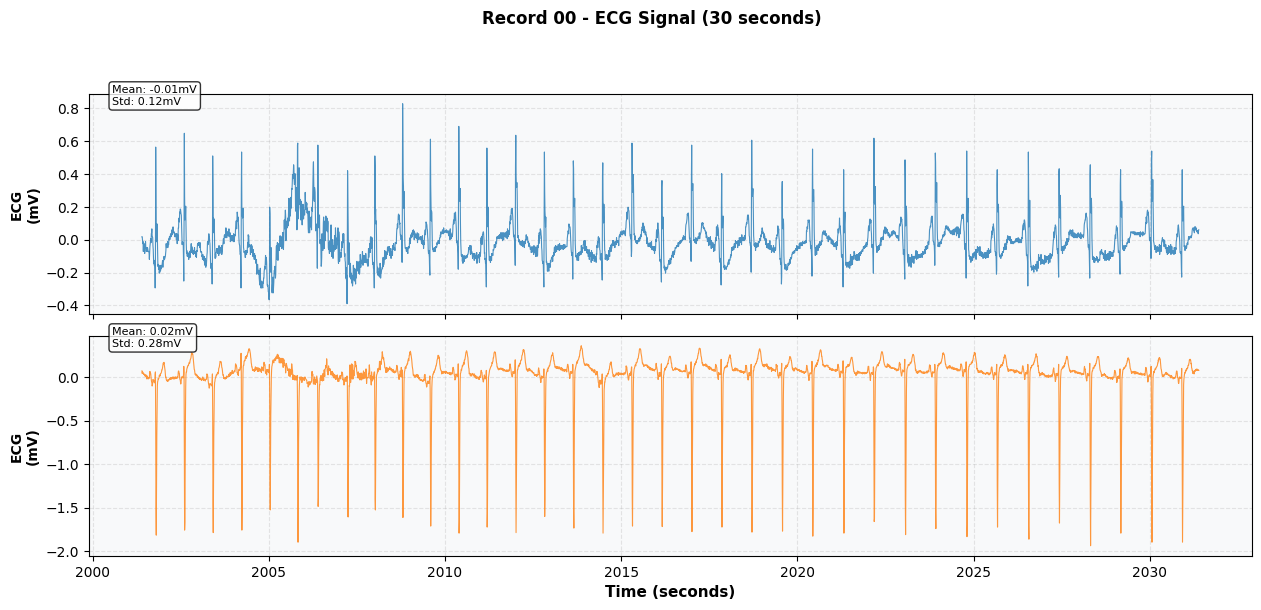

2. Plotting ECG signal with annotations...


C:\Users\dorax\AppData\Local\Temp\ipykernel_19360\1785515813.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


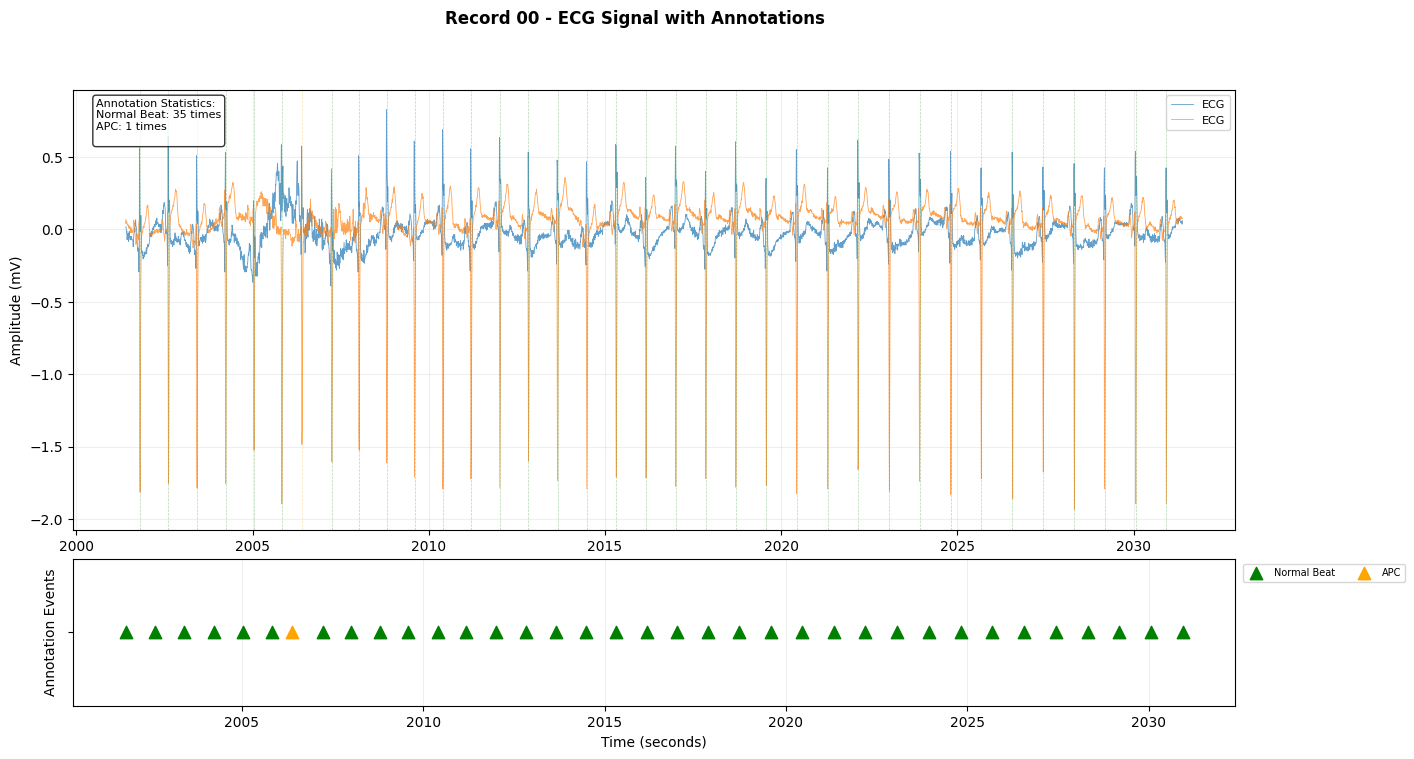

3. Performing frequency analysis...


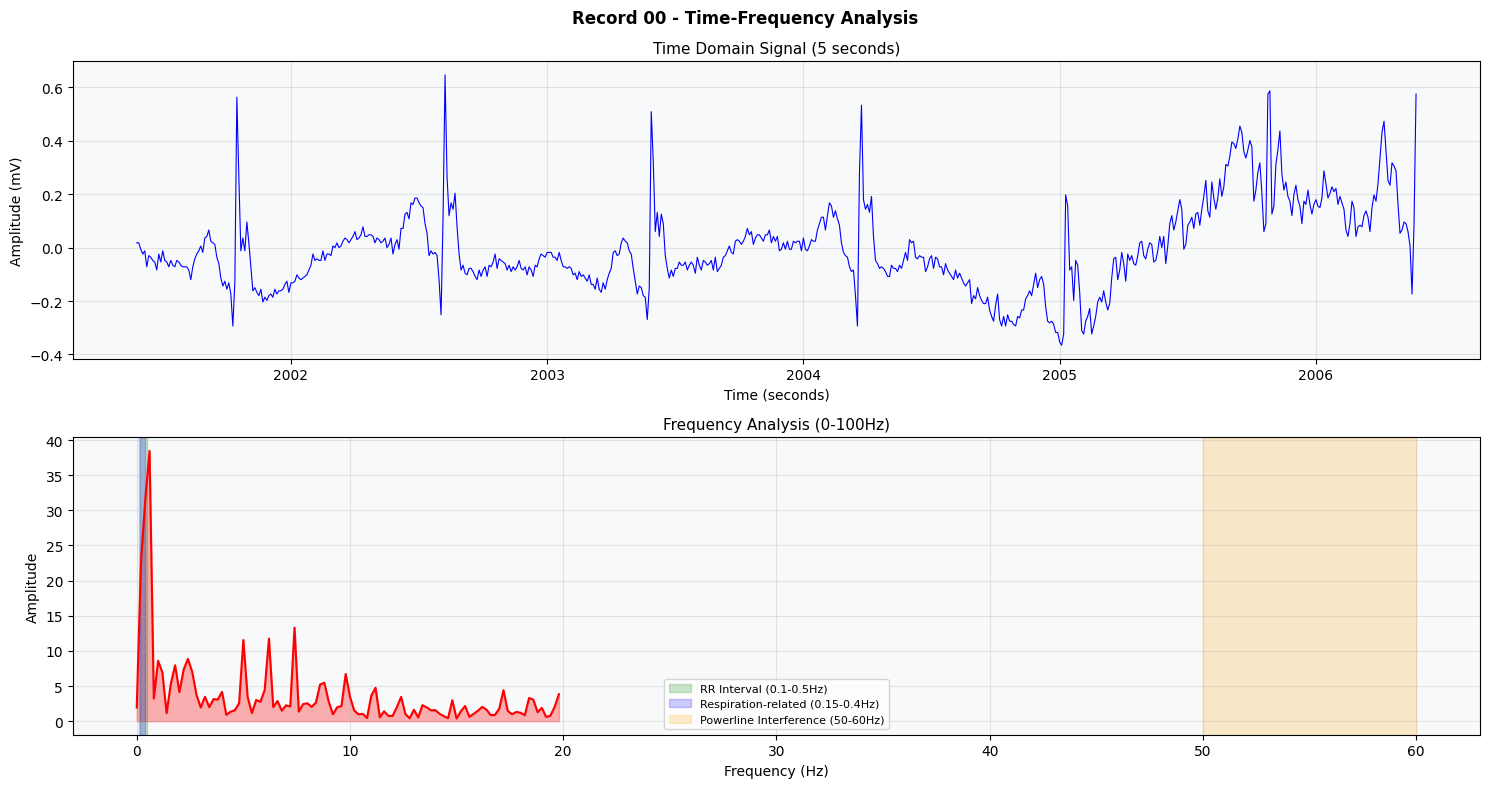

4. Analyzing heart rate variability...
  ⚠️  HRV analysis failed: 'purple-' is not a valid format string (unrecognized character 'u')
5. Analyzing lead comparison...


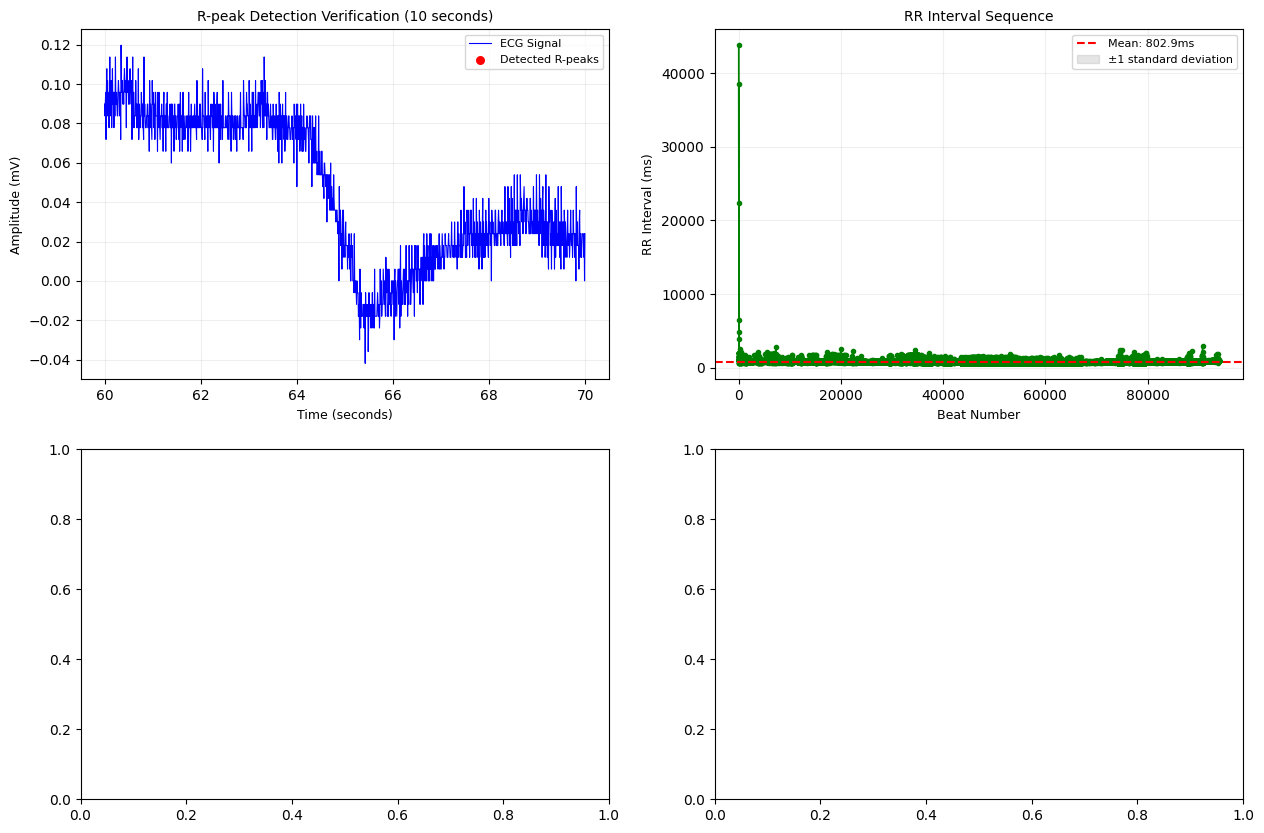

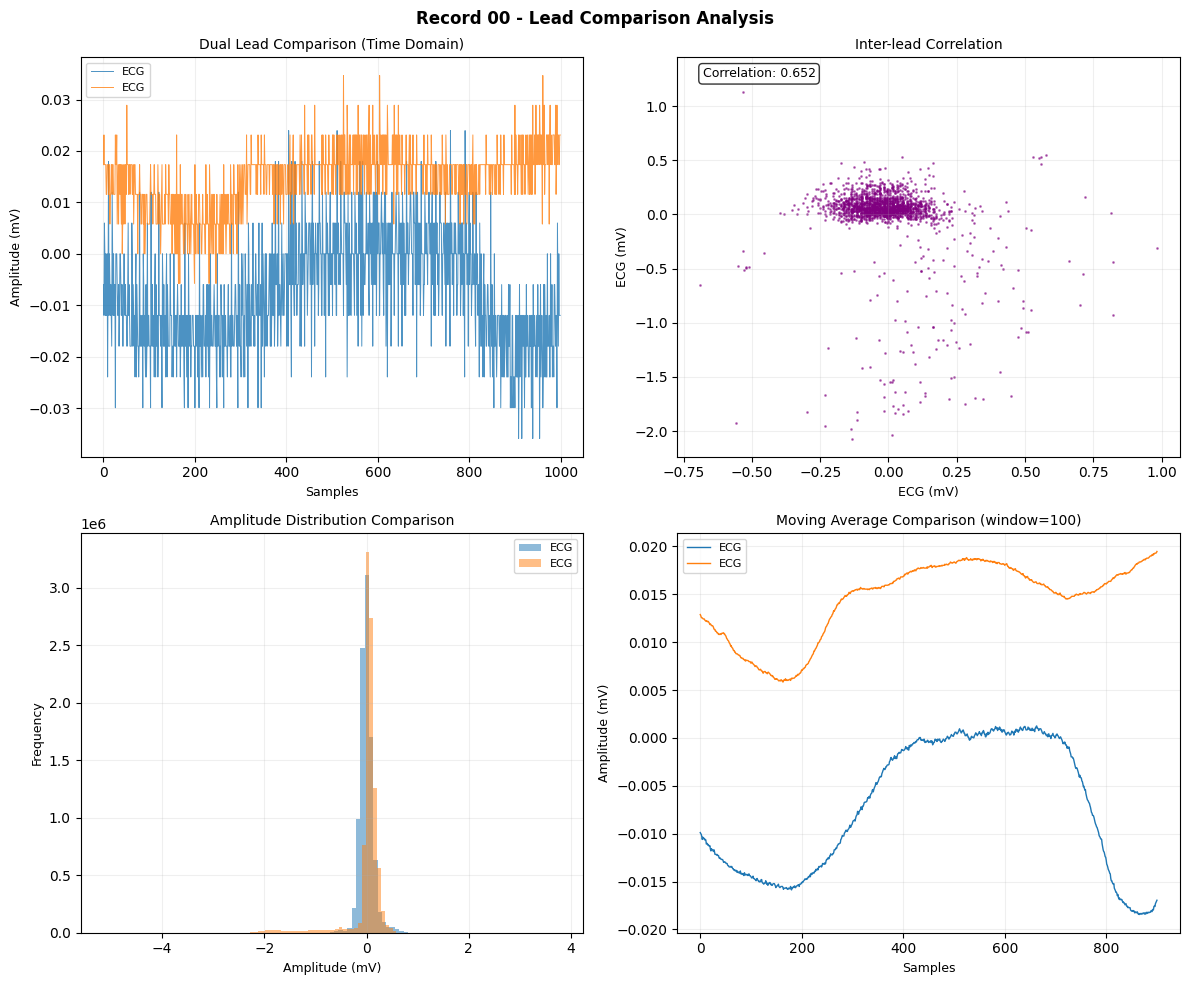

6. Generating comprehensive report...


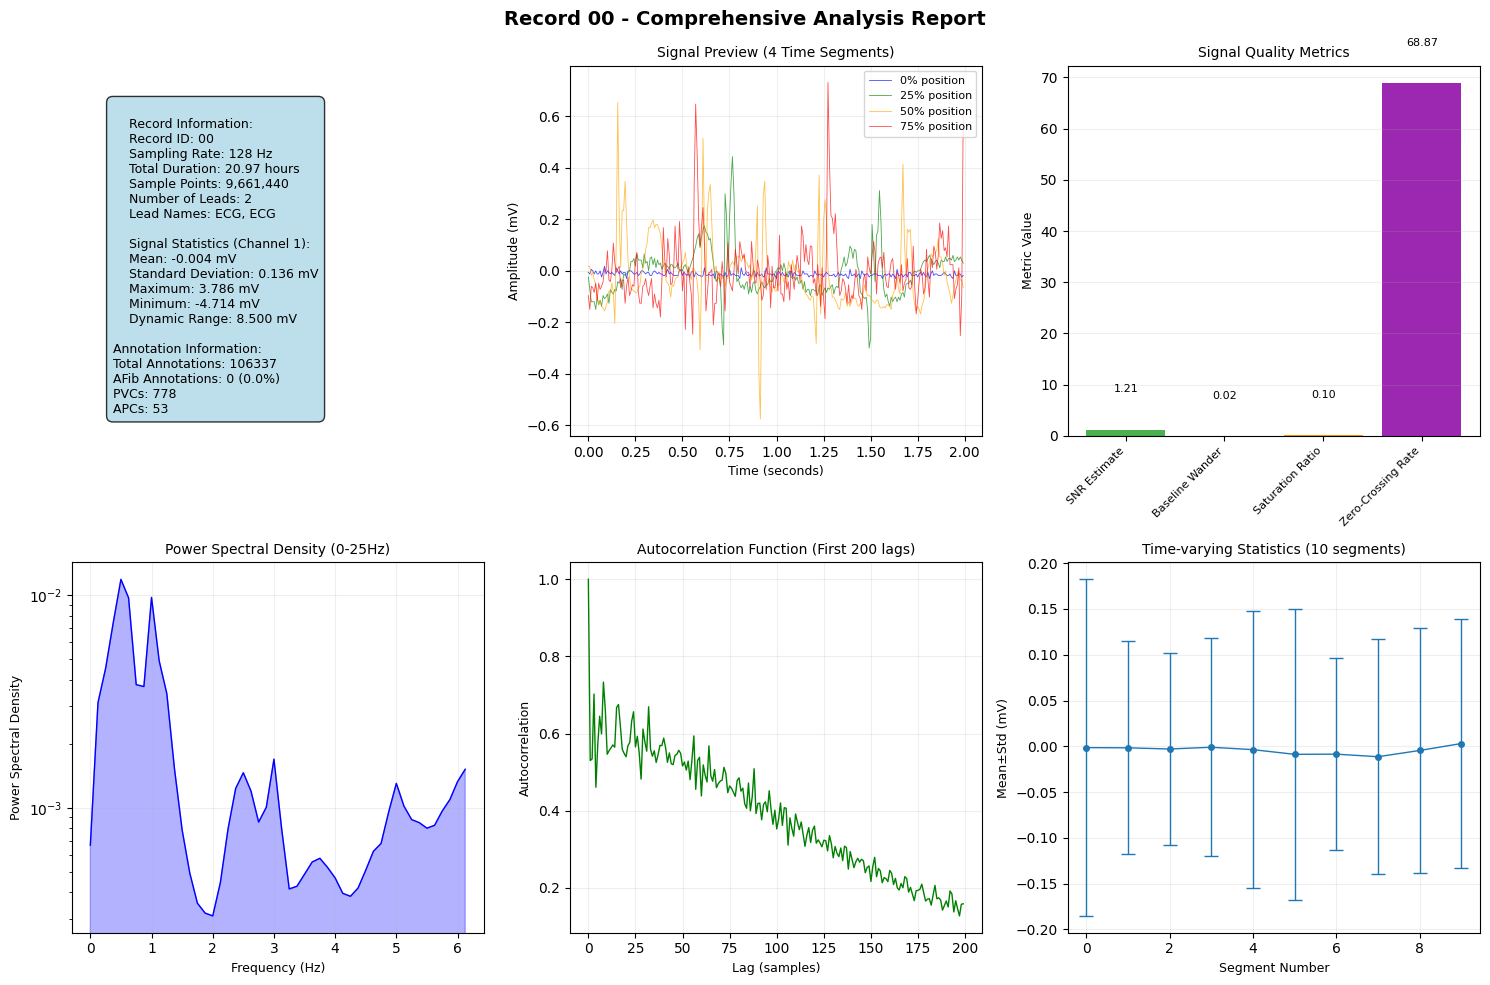


✅ Record 00 visualization completed!
📁 All plots saved to: visualizations/00/


In [ ]:
# 1. 首先查找有标注的片段
if len(all_ecg_records) > 0:
    record = all_ecg_records[0]
    
    # 查找包含有趣标注的片段
    segments = find_annotated_segments(record)
    
    if segments:
        # 2. 可视化第一个有标注的片段
        first_seg = segments[0]
        start_time = first_seg['start_time']
        
        # 转换为时:分:秒
        hours = int(start_time // 3600)
        minutes = int((start_time % 3600) // 60)
        seconds = int(start_time % 60)
        
        print(f"\nVisualizing segment with {first_seg['symbol_name']}")
        print(f"   Starting at: {hours:02d}:{minutes:02d}:{seconds:02d}")
        
        # 3. 运行改进的可视化
        visualize_specific_record_improved(
            record, 
            start_sec=start_time,
            duration_sec=30,
            save_plots=True
        )
    else:
        print("No interesting annotations found, trying random time...")
        # 随机选择一个时间
        import random
        total_duration = record['signals'].shape[0] / record['fs']
        random_time = random.uniform(3600, total_duration - 3600)  # 避免开头结尾
        
        visualize_specific_record_improved(
            record,
            start_sec=random_time,
            duration_sec=30,
            save_plots=True
        )